# Malaria predictor: an image classification problem
# Testing a trained model on the test dataset

This notebook read and load the test dataset, then load a pre-trained CNN model to predict on test images and evaluate the performance of the model. We have trained the model on Azure machine learning services and now we need to evaluate the resulting model.  

### Loading the libraries and setting global variables

In [1]:
import os
import random
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import numpy as np

%matplotlib inline 

In [2]:
#Defining global varibles
from datetime import datetime

# Set the name of the filename where the predictions on the test set will be saved
now = datetime.now() # current date and time
results_file='Submit_'+now.strftime("%Y%m%d%H%M%S")+'.csv'
# Model name in json format and its weights in H5
model_name='model_generator.json'
model_weights = 'model_generator.h5'
# Size or number of test images to predict on
size_test_data = 5793

#root folder
root_folder='..'
# Set the folder with the dataset or images
data_folder_name='Datasets/malaria_data'
DATA_PATH = os.path.abspath(os.path.join(root_folder, data_folder_name))

# Set the folder with the test dataset or images
test_path = os.path.join(DATA_PATH, "test")
# Read the filenames of the images
test_images = glob(os.path.join(test_path, "*.jpg"))
# Store the filenames in a list
test_filenames = [os.path.basename(i) for i in test_images]


In [3]:
results_file

'Submit_20190530194854.csv'

In [4]:
len(test_filenames)

5793

### Analyzing size of test images and check if they are normalized

In [5]:
# Show some images using matplotlib
r = random.sample(test_images, 16)
img=plt.imread(r[0])

print('Data type: %s' % img.dtype)
print('Min: %.3f Max: %.3f ' %(img.min(),img.max()))

img= img/255

print('Data type: %s' % img.dtype)
print('Min: %.3f Max: %.3f ' %(img.min(),img.max()))


Data type: uint8
Min: 0.000 Max: 255.000 
Data type: float64
Min: 0.000 Max: 1.000 


### Ploting some test images

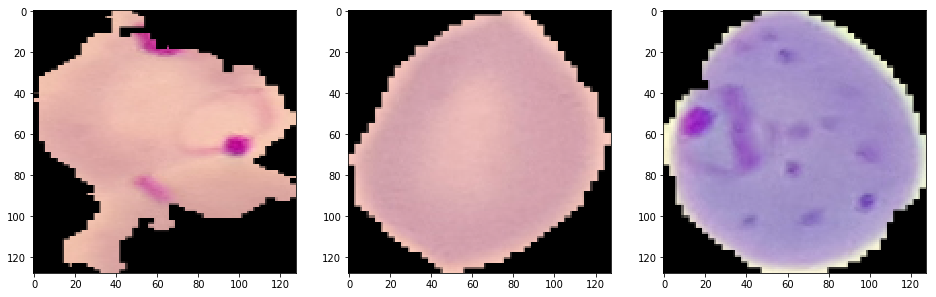

In [5]:
r = random.sample(test_images, 3)

# Matplotlib black magic
plt.figure(figsize=(16,16))
plt.subplot(131)
plt.imshow(plt.imread(r[0]))

plt.subplot(132)
plt.imshow(plt.imread(r[1]))

plt.subplot(133)
plt.imshow(plt.imread(r[2]));    

plt.show()

### Loading the test images and preprocess them

In [6]:
# Processing the images to normalize them and convert to numpy arrays
def normalize(x):
    return (x.astype(float)/255.0)

def proc_images(n,images,labels=None):
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """

    x = [] # images as arrays
    y = [] # labels Infiltration or Not_infiltration

    for img in images[:n]:
        base = os.path.basename(img)
        if labels!=None:
            label = labels["infected"][labels["filename"] == base].values[0]
            y.append(label)

        # Read the image
        my_image = plt.imread(img)
        # Apend to the array and normalize
        x.append(normalize(my_image))
#        x.append(my_image)
        # Append the label to the array
    return x,y

img_array,label_array=proc_images(size_test_data,test_images)
print('Images: ', len(img_array))
print('Image Shape:', img_array[0].shape)
#print('Labels: ',len(label_array))

Images:  5793
Image Shape: (128, 128, 3)


In [7]:
# Save the test images preprocessed on a disk file
np.savez_compressed(DATA_PATH+"/test_images_arrays", img_array)


### Load the model and its weights and parameters

In [8]:
from keras.models import model_from_json
# load json and create model
json_file = open(model_name, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(model_weights)
print("Loaded model from disk")
 

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Loaded model from disk


### Loading the numpy array with test images from disk

In [9]:
# Load npz file containing image arrays
test_npz = np.load(DATA_PATH+"/test_images_arrays.npz")
X_test = test_npz['arr_0']
#print(x)
print('Shape',X_tenst.shape)

Shape (5793, 128, 128, 3)


Now, it is time to predict on the test images and evaluate the model performance

In [10]:
# Predict probabilities of X_test 
Y_pred = loaded_model.predict_proba(X_test).astype('float64')
print('Y_pred Shape: ',Y_pred.shape)

Y_pred Shape:  (5793, 1)


In [11]:
infected = np.sum(Y_pred[:,0]>=0.5)
non_infected = np.sum(Y_pred[:,0]<0.5)
print('Infected: ',infected,' No Infected: ',non_infected)
#Y_pred[Y_pred[:,0]]
#infected =Y_pred

Infected:  2934  No Infected:  2859


### Create a csv file with the prediction probabilty of each test image

In [12]:
result_df=pd.DataFrame(columns=['filename','infected'])
result_df['filename']=test_filenames[:size_test_data]
result_df['infected']=Y_pred
result_df.to_csv(results_file,sep=',',header=True,index=False,index_label=False)
result_df

,filename,infected
0,21765.jpg,0.551824
1,21766.jpg,0.999761
2,21767.jpg,0.085159
3,21768.jpg,0.001972
4,21769.jpg,0.000935
5,21770.jpg,0.977270
6,21771.jpg,0.047790
7,21772.jpg,0.029166
8,21773.jpg,0.999370
9,21774.jpg,0.035955
